In [1]:
import numpy as np
import pandas as pd
import chromATAC as ca
from chromATAC.integrated import IntData
from pycirclize import Circos
from pycirclize.utils import ColorCycler
import collections
import matplotlib.pyplot as plt
from pathlib import Path

from pycirclize import Circos
from pycirclize.utils import load_eukaryote_example_dataset

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
parent_dir = '/Users/mossishahi/Code/lupien/IntData'

In [4]:
def Clustered_TEs(chromosome_layer, **kwargs):
    resolution = kwargs.get('resolution')
    conditions = {}
    annotations = {}
    resolution = kwargs.get('resolution')
    ann = {0:'TE with no defined CORTE in any chromosome', 1:'TE with defined CORTEs'}
    for chr in range(1, 25):
        idx = np.array([i.split('>')[-1] for i in ind.chr.layers[resolution]['TEs']['index'][chr]])
        conditions[chr] = np.array([int(i in idx) for i in chromosome_layer['index'][chr]])
        annotations[chr] = ann
    return conditions, annotations

def get_cancertype(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}
    resolution=kwargs.get('resolution')
    ann = {i:v for i, v in enumerate(tcga_met[' Project'].apply(lambda x:x.split('TCGA-')[-1]).unique())}
    mapping = {v:i for i, v in enumerate(tcga_met[' Project'].apply(lambda x:x.split('TCGA-')[-1]).unique())}
    for chr in ca.info.CHROMOSOMES['numericals'].values():
        samples = chromosome_layer['index'][chr]
        conditions[chr] = [mapping[i.split('_')[0].split('>')[-1]] for i in ind.chr.layers[resolution]['TCGA']['index'][chr]]
        annotations[chr] = ann
    return conditions, annotations
    
def CTeCore_filter(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}    
    ann = {0:'TEs with No Significant Difference between #Cores and #Elements in this Chromosome', 1:'TEs with Significant Difference between #Cores and #Elements in this Chromosome'}
    index = kwargs.get('index')
    test_res = kwargs.get('test_res')
    maj = kwargs.get('majority', 3)
    for chr in range(1, 25):
        idx = np.array([i.split('>')[-1] for i in index[test_res[:, chr-1]>=maj]])
        conditions[chr] = np.array([int(i.split('>')[-1] in idx) for i in chromosome_layer['index'][chr]])
        annotations[chr] = ann
    return conditions, annotations

def GTeCore_filter(genome_layer, **kwargs):
    conditions = {}
    annotations = {}
    ann = {0:'TEs with No Significant Difference between #Cores and #Elements in this Chromosome', 1:'TEs with Significant Difference between #Cores and #Elements in this Chromosome'}
    index = kwargs.get('index')
    test_res = kwargs.get('test_res')
    maj = kwargs.get('majority', 3)
    for chr in range(1, 25):
        idx = np.array([i.split('>')[-1] for i in index[test_res[:, chr-1]>=maj]])
        conditions[chr] = np.array([int(i.split('>')[-1] in idx) for i in genome_layer['index']])
        annotations[chr] = ann
    return conditions, annotations

def save_correlation(omic, layers, resolution, chr='all', path=".", cmp_method='sim'):
    metrs = ['score', 'pvalue']
    if chr=='all':
        chr=ca.info.CHROMOSOMES['names']
    if not isinstance(chr, list):
        chr = [chr]
    for c in chr:
        path = os.path.join(path, cmp_method+f'/{c}')
        if not os.path.exists(path):
            os.makedirs(path)
        for m in metrs:
            for k, v in omic.layers[resolution]['co'][tuple(sorted(set(layers)))][cmp_method][c][m].items():
                v.to_csv(f'{path}/{c}_{k}_{m}.csv')
def tcga_mapping(name):
    return f"{tcga_met.iloc[np.where([i in name for i in tcga_met['File Name'].apply(lambda x: x.split('_')[0].split('-')[-1])])[0]][' Project'].apply(lambda x:x.split('TCGA-')[-1]).values[0]}_{name}"

### TE and COTEs

In [92]:
ind = IntData()

ind.add_layer("TEs", input=parent_dir+'/data/V2-TEs/non_olap', index_mapper=lambda x: x.split("_Merged.bed")[0])
ind.add_layer("CoTEs", input=parent_dir+'/data/V2-TEs/cores1000', index_mapper=lambda x: x.split("_Merged.bed")[0])

loading files from: /Users/mossishahi/Code/lupien/IntData/data/V2-TEs/non_olap


100%|█████████████████████████████████████████████████████████████████████████████████| 975/975 [00:08<00:00, 108.81it/s]


loading files from: /Users/mossishahi/Code/lupien/IntData/data/V2-TEs/cores1000


100%|████████████████████████████████████████████████████████████████████████████████| 456/456 [00:00<00:00, 1188.61it/s]


In [93]:
def TE_family(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}    
    ann = {i:te.split('>')[-1] for i, te in enumerate(ind.chr.layers[1e06]['TEs']['index'][1])}
    con = {te.split('>')[-1]:i for i, te in enumerate(ind.chr.layers[1e06]['TEs']['index'][1])}
    for chr in range(1, 25):
        conditions[chr] = np.array([con[i.split('>')[-1]] for i in chromosome_layer['index'][chr]])
        annotations[chr] = ann
    return conditions, annotations

In [94]:
def CoTE_family(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}    
    ann = {i:te.split('>')[-1] for i, te in enumerate(ind.chr.layers[1e06]['CoTEs']['index'][1])}
    con = {te.split('>')[-1]:i for i, te in enumerate(ind.chr.layers[1e06]['CoTEs']['index'][1])}
    for chr in range(1, 25):
        conditions[chr] = np.array([con[i.split('>')[-1]] for i in chromosome_layer['index'][chr]])
        annotations[chr] = ann
    return conditions, annotations

In [95]:
ind.chr.add_filter('te_family', TE_family, ['TEs'])
ind.chr.add_filter('cote_family', CoTE_family, ['CoTEs'])

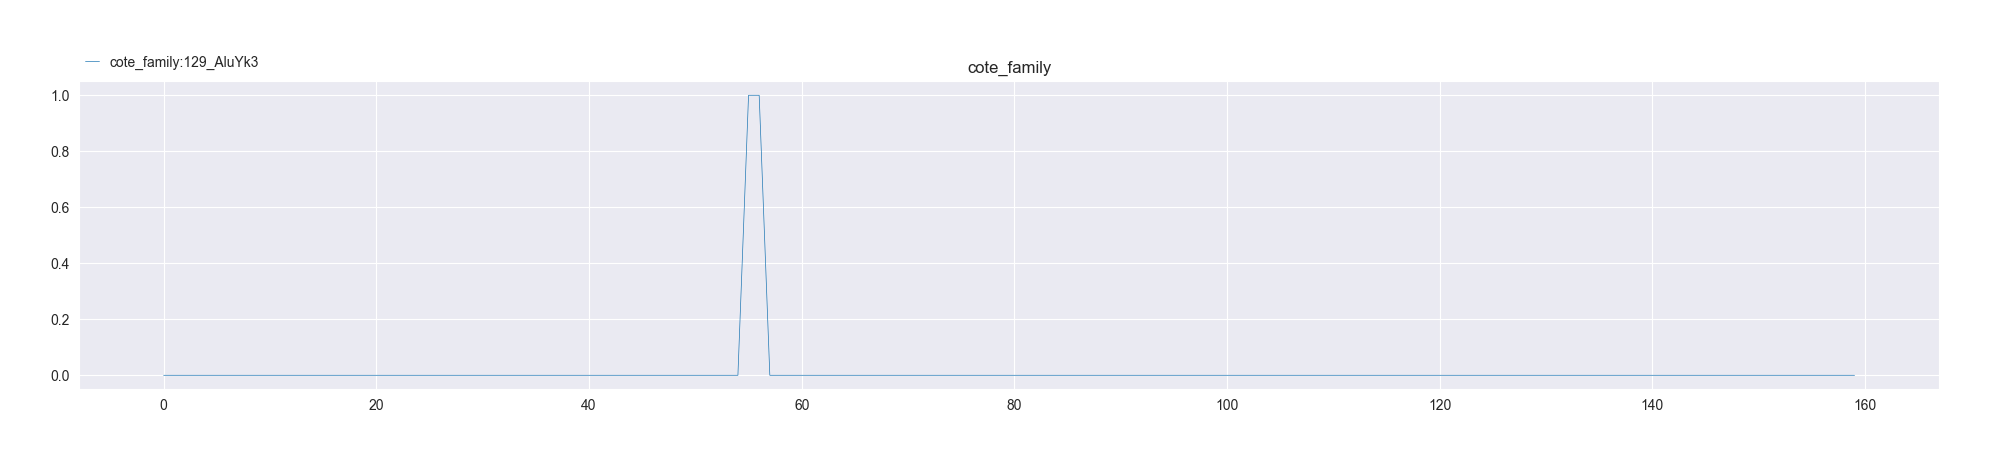

In [108]:
fam = '129_AluYk3'
c = 'chr7'
fig = ca.pl.plot_layer(ind.chr, 'CoTEs', chrom=c, groups={'cote_family':fam}, normal_y=False)
fig.savefig(f'{fam}-{c}.png')

In [82]:
def plot_circos(c, te_family='542_L1MA1', fig=False):
    np.random.seed(0)
    ColorCycler.set_cmap("tab10")
    chr_bed_file = Path(f'./chromosomes/{c}.bed')
    cytoband_file = Path('./cytoBand.txt')
    te_df = pd.read_csv(parent_dir+f'/data/V2-TEs/non_olap/{te_family}_Merged.bed', sep='\t', names=['chr', 'start', 'end'], index_col=False)
    te_df = te_df[te_df['chr']==c]
    
    cote_df = pd.read_csv(parent_dir+f'/data/V2-TEs/cores1000/{te_family}_Merged.bed',sep='\t', names=['chr', 'start', 'end'], index_col=False)
    cote_df = cote_df[cote_df['chr']==c]

    # cote_df[cote_df['chr']==c][['start', 'end']].values
    # Initialize Circos from BED chromosomes
    circos = Circos.initialize_from_bed(chr_bed_file, space=3, start=45, end=360, endspace=False)
    # circos.text("Homo sapiens (hg38)", size=15)
    
    circos.add_cytoband_tracks((97, 100), cytoband_file)
        
    for sector in circos.sectors:
        megabp = sector.add_track((92, 97))
        rect_size = 1e07
        for i in range(int(megabp.size / rect_size)+1):
            x1, x2 = i * rect_size, min(i * rect_size + rect_size, sector.size)
            megabp.rect(x1, x2, ec="black", lw=0.5, color=ColorCycler())
            megabp.text(str(i + 1)+' Mbp', (x1 + x2) / 2, size=8, color="white")
            
        te = sector.add_track((83, 92))
        te.rect(0, te.size, fc='khaki')
        for (chr, start, end) in te_df.values:
            te.rect(start, end, color='mediumseagreen', ec='mediumseagreen', lw=.08, alpha=.3)
            
        cote = sector.add_track((73, 83), )
        cote.rect(0, cote.size, fc='lightgoldenrodyellow')
        for (chr, start, end) in cote_df.values:
            cote.rect(start, end, color='seagreen')
            
    text_common_kws = dict(ha="left", va="center", size=8)
    # circos.text(" 1. Idiogram", r=98.5, color="black", **text_common_kws)
    # circos.text(" 2. Mega Base Pairs", r=95, color="black", **text_common_kws)
    circos.text(" (TE) Transpose Elements", r=87.5, color="black", **text_common_kws)
    circos.text(" (CoTE) Clusters of Transpose Elements", r=78, color="black", **text_common_kws)
    circos.text(f"Chromosome {c.split('chr')[-1]} \n\n\n TEs vs CoTEs \n\n TE family: {te_family.split('_')[-1]}", size=14)
    fig = circos.plotfig()
    fig.savefig(f"./{c}_circos.png")
    if fig:
        return fig

/var/folders/dh/z5vdtxqd23qd9l10wsz4vjbw0000gp/T/ipykernel_47306/1014881659.py:6: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  te_df = pd.read_csv(parent_dir+f'/data/V2-TEs/non_olap/{te_family}_Merged.bed', sep='\t', names=['chr', 'start', 'end'], index_col=False)


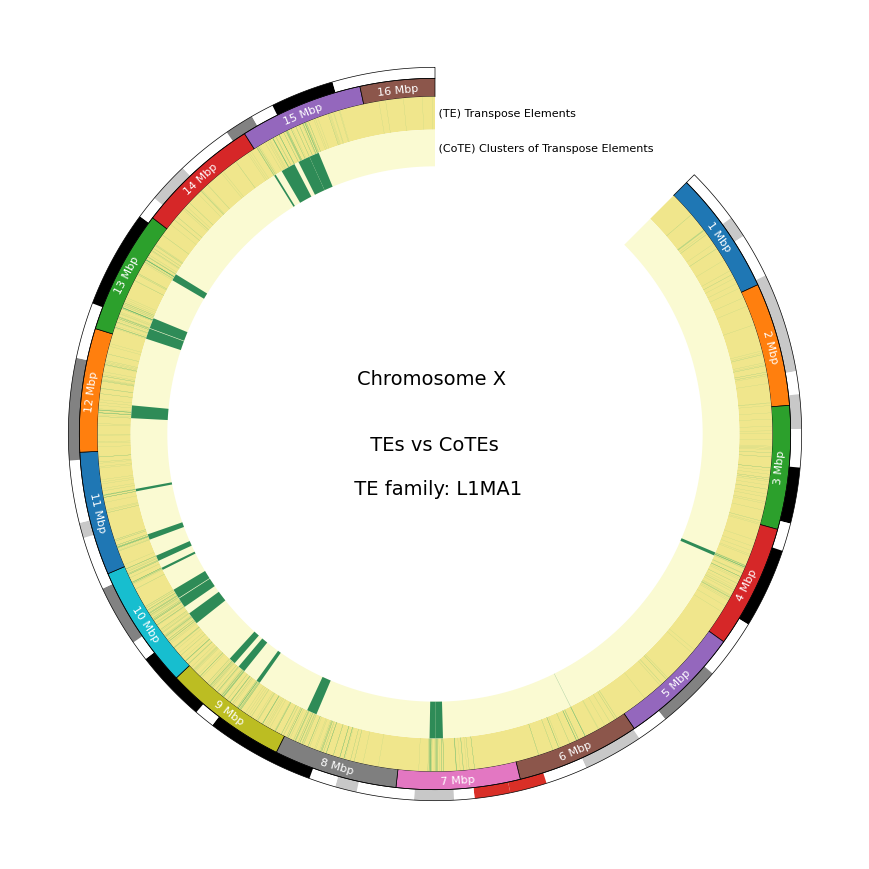

In [86]:
c = 'chrX'
family = '542_L1MA1'
fig=plot_circos(c, family)
fig.savefig(f'./{family}-{c}.png')

/var/folders/dh/z5vdtxqd23qd9l10wsz4vjbw0000gp/T/ipykernel_47306/1014881659.py:6: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  te_df = pd.read_csv(parent_dir+f'/data/V2-TEs/non_olap/{te_family}_Merged.bed', sep='\t', names=['chr', 'start', 'end'], index_col=False)


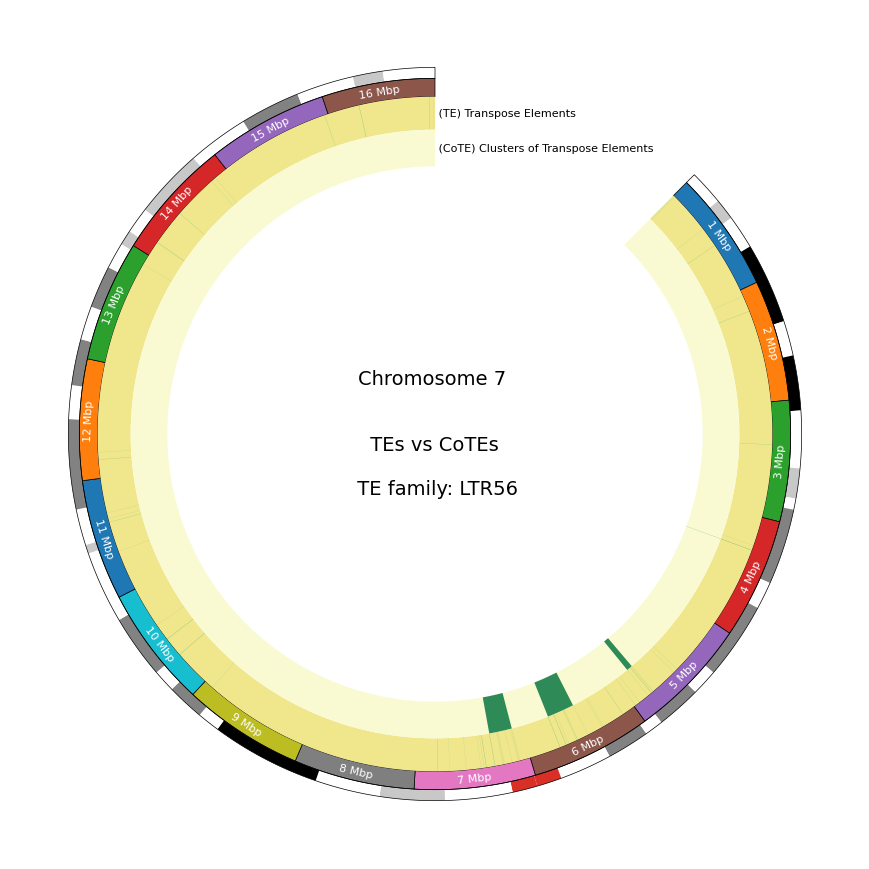

In [87]:
c = 'chr7'
family = '813_LTR56'
fig=plot_circos(c, family)
fig.savefig(f'./{family}-{c}.png')

/var/folders/dh/z5vdtxqd23qd9l10wsz4vjbw0000gp/T/ipykernel_47306/1014881659.py:6: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  te_df = pd.read_csv(parent_dir+f'/data/V2-TEs/non_olap/{te_family}_Merged.bed', sep='\t', names=['chr', 'start', 'end'], index_col=False)


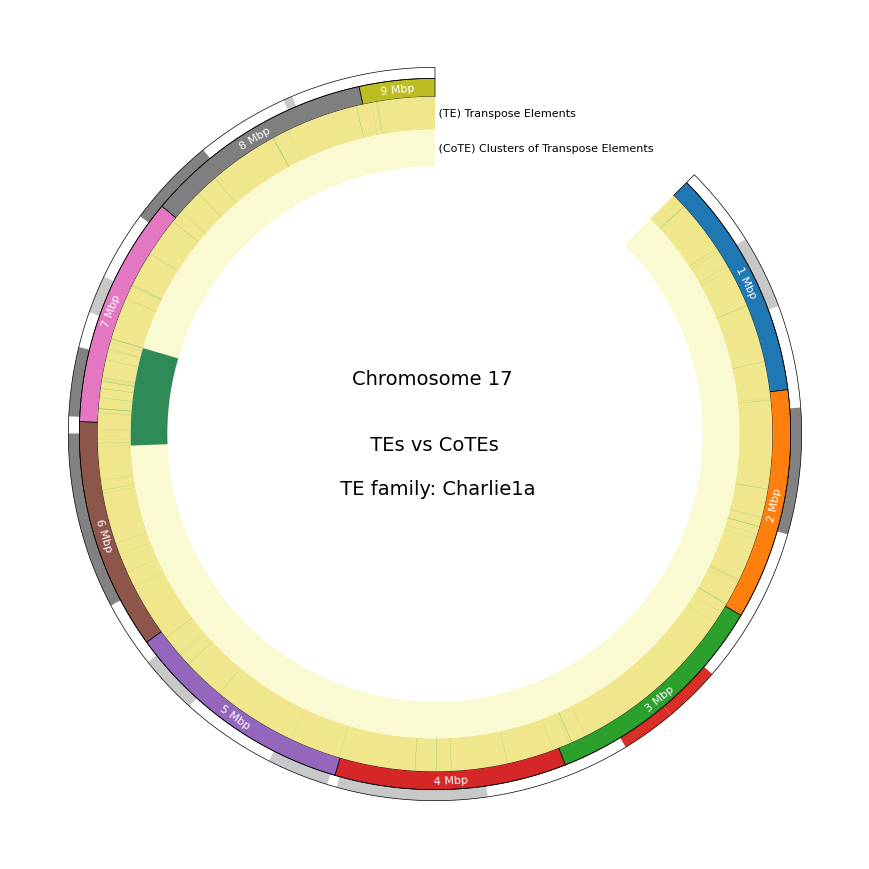

In [88]:
c = 'chr17'
family = '300_Charlie1a'
fig=plot_circos(c, family)
fig.savefig(f'./{family}-{c}.png')

/var/folders/dh/z5vdtxqd23qd9l10wsz4vjbw0000gp/T/ipykernel_47306/652917445.py:6: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  te_df = pd.read_csv(parent_dir+f'/data/V2-TEs/non_olap/{te_family}_Merged.bed', sep='\t', names=['chr', 'start', 'end'], index_col=False)


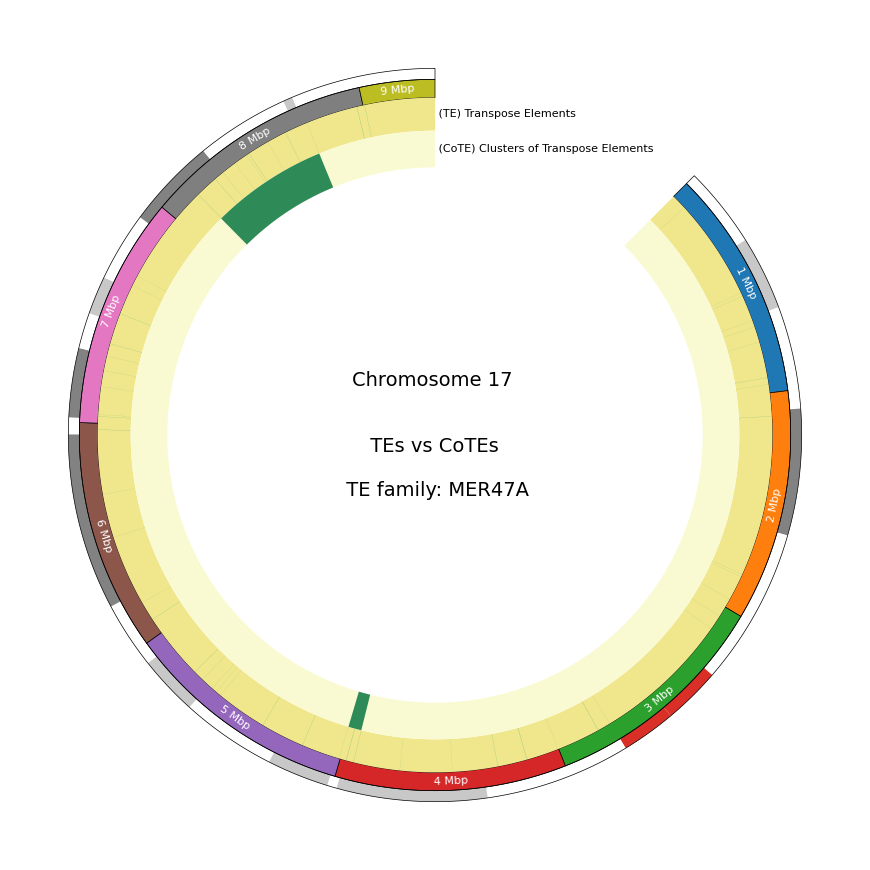

In [80]:
c = 'chr17'
plot_circos(c, '996_MER47A')